# Exploiting Music Source Separation for Automatic Lyrics Transcription with Whisper

## Set up

In [3]:
# STDLIB
import itertools
import os

# THIRDPARTY
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# FIRSTPARTY
from alt.alt_types import InferLevel, LongFormAlgo
from alt.util import read_pz, infer_dir, share_dir, data_root

# Set up
NUM_ITERATIONS=5
sns.set_theme()
results_dir = share_dir() / "01-ss"
results_dir.mkdir(exist_ok=True)

## Short form

### Load data

In [ ]:
audios: list[str] = [
    "original",
    "mdx",
    "mdx_extra",
    "vocal_stem",
]
eval_types: list[InferLevel] = [
    InferLevel.MERGED_LINE,
    InferLevel.GROUPED_LINE,
]
samples, chunks, edits = [], [], []
for audio, level in itertools.product(audios, eval_types):
    for idx in range(NUM_ITERATIONS):
        s, c, e = read_pz(infer_dir() / f"01-ss-short-{audio}-{level}-{idx}" / "dataframes.pz")
        for df in s, c, e:
            df["audio"] = audio
            df["level"] = str(level)
            df["iter_idx"] = idx
        samples.append(s)
        chunks.append(c)
        edits.append(e)
df_samples_short = pd.concat(samples)
df_chunks_short = pd.concat(chunks)
df_edits_short = pd.concat(edits)

### Segment length summary

In [23]:
df = df_samples_short.query("audio == 'original' & level != 'song' & iter_idx == 0").drop(
    ["wer", "uid", "language", "sample_idx", "ref", "hyp"], axis=1
)

# print basic stats
df["len_secs"] = df["end"] - df["start"]
pivot_table = df.pivot_table(
    index=["dataset", "level"],
    values="len_secs",
    aggfunc=["mean", "std", "min", "max", lambda row: int(len(row))],
)
# Rename columns and index
pivot_table.columns = ["Mean", "Std. Dev", "Min.", "Max.", "Count"]
# Reorder so that level part of index is in order merged_line, grouped_line
level_order = ["InferLevel.MERGED_LINE", "InferLevel.GROUPED_LINE"]
pivot_table = pivot_table.reindex(
    pd.MultiIndex.from_product(
        [pivot_table.index.levels[0], level_order],
        names=pivot_table.index.names
    )
).dropna(how="all")
pivot_table.columns = [f"\\textbf{{{col}}}" for col in pivot_table.columns]
pivot_table.index.names = [f"\\textbf{{{col}}}" for col in pivot_table.index.names]
pivot_table = pivot_table.rename(
    index={
        "InferLevel.MERGED_LINE": "Merged line",
        "InferLevel.GROUPED_LINE": "Group",
        "jam-alt": "JAM-ALT",
        "musdb-alt": "MUSDB-ALT",
    }
)
pivot_table = pivot_table.round(2)
display(pivot_table)

# Save table to tex file and print
# Format the DataFrame before styling
# Apply styling and convert to LaTeX
latex_table = pivot_table.style.format_index(escape="latex").format_index(
    escape="latex", axis=1
)
(results_dir / "segment_length_summary.tex").write_text(
    latex_table.to_latex(hrules=True, column_format="ll|rrrrr"), encoding="utf-8"
)

\textbf{Mean}  \textbf{Std. Dev}  \
\textbf{dataset} \textbf{level}                                     
JAM-ALT          Merged line              3.52               1.80   
                 Group                   24.25               3.71   
MUSDB-ALT        Merged line              4.59               2.39   
                 Group                   23.43               4.18   

                                 \textbf{Min.}  \textbf{Max.}  \textbf{Count}  
\textbf{dataset} \textbf{level}                                                
JAM-ALT          Merged line              0.50          17.66            3445  
                 Group                    3.64          29.96             518  
MUSDB-ALT        Merged line              1.22          23.82            1488  
                 Group                    2.27          29.95             305

618

### Error rate table

In [24]:
rename_dict = {
    "sub_rate": "SR",
    "del_rate": "DR",
    "ins_rate": "IR",
    "wer": "WER",
    "hal_rate": "IR_Hal",
    "del_nl_rate": "DR_NL",
    "del_bv_rate": "DR_BV",
}
rename_dict_dataset = {
    "jam-alt": "JAM-ALT",
    "musdb-alt": "MUSDB-ALT",
}
rename_dict_audio = {
    "original": "Original Mix",
    "mdx_extra": "Separated (mdx_extra)",
    "mdx": "Separated (mdx)",
    "vocal_stem": "Vocal Stem",
}
rename_dict_level = {"InferLevel.GROUPED_LINE": "Group", "InferLevel.MERGED_LINE": "Merged line"}


def map_chunk(row):
    for typ in ["hit", "sub", "ins", "del"]:
        row[typ] = row["len"] if row["typ"] == typ else 0
    row["hal"] = row["ins"] if row["ins"] > 10 else 0
    return row


# Convert chunks to hit/sub/ins/del/hal counts
df = df_chunks_short[["level", "typ", "len", "dataset", "audio", "nl", "bv"]].copy()
df["hit"] = (df["typ"] == "hit") * df["len"]
df["sub"] = (df["typ"] == "sub") * df["len"]
df["ins"] = (df["typ"] == "ins") * df["len"]
df["del"] = (df["typ"] == "del") * df["len"]
df["del_nl"] = (df["typ"] == "del") * df["nl"]
df["del_bv"] = (df["typ"] == "del") * df["bv"]
df["hal"] = (df["ins"] > 10) * df["ins"]

df = df.groupby(["dataset", "audio", "level"]).sum().reset_index()

# compute rates
df["ref_len"] = df["sub"] + df["hit"] + df["del"]
df["wer"] = (df["sub"] + df["del"] + df["ins"]) / df["ref_len"]
df["ins_rate"] = df["ins"] / df["ref_len"]
df["del_rate"] = df["del"] / df["ref_len"]
df["del_nl_rate"] = df["del_nl"] / df["ref_len"]
df["del_bv_rate"] = df["del_bv"] / df["ref_len"]
df["sub_rate"] = df["sub"] / df["ref_len"]
df["hal_rate"] = df["hal"] / df["ref_len"]

# Create table
df = df.sort_values("audio").reset_index()
df["audio"] = pd.Categorical(
    df["audio"], categories=["original", "mdx", "mdx_extra", "vocal_stem"], ordered=True
)
df["level"] = pd.Categorical(df["level"], categories=["InferLevel.GROUPED_LINE", "InferLevel.MERGED_LINE"], ordered=True)
df[
    [
        "wer",
        "sub_rate",
        "del_rate",
        "ins_rate",
        "hal_rate",
        "del_nl_rate",
        "del_bv_rate",
    ]
] *= 100
pivot_table = df.pivot(
    index=["level", "audio"],
    columns=["dataset"],
    values=[
        "wer",
        "sub_rate",
        "del_rate",
        "ins_rate",
        "hal_rate",
        "del_nl_rate",
        "del_bv_rate",
    ],
)
pivot_table = (
    pivot_table.swaplevel(0, 1, axis=1)
    .sort_index(axis=1, level=0, sort_remaining=False)
    .rename(columns=rename_dict_dataset, level=0)
    .rename(columns=rename_dict, level=1)
    .rename(index=rename_dict_audio, level=1)
    .rename(index=rename_dict_level, level=0)
    .rename_axis(
        index={"level": "Type", "audio": "Audio"}, columns={"dataset": "Dataset"}
    )
)

pivot_table = (
    pivot_table.style.format(
        "{:.2f}",
        na_rep="-",
        subset=pd.IndexSlice[
            :, pd.IndexSlice[:, ["WER", "SR", "DR", "IR", "DR_NL", "DR_BV", "IR_Hal"]]
        ],
    )
    .highlight_min(
        axis=0,
        props="font-weight:bold;",
        subset=pd.IndexSlice[
            pd.IndexSlice[
                ["Group"],
                ["Original Mix", "Separated (mdx)", "Separated (mdx_extra)"],
            ],
            :,
        ],
    )
    .highlight_min(
        axis=0,
        props="font-weight:bold;",
        subset=pd.IndexSlice[
            pd.IndexSlice[
                ["Merged line"],
                ["Original Mix", "Separated (mdx)", "Separated (mdx_extra)"],
            ],
            :,
        ],
    )
)

display(pivot_table)
latex_table = pivot_table.format_index(escape="latex").format_index(
    escape="latex", axis=1
)
(results_dir / "verse_error_table.tex").write_text(
    latex_table.to_latex(convert_css=True), encoding="utf-8"
)

\begin{tabular}{llrrrrrrrrrrrrrr}
 & Dataset & \multicolumn{7}{r}{JAM-ALT} & \multicolumn{7}{r}{MUSDB-ALT} \\
 &  & WER & SR & DR & IR & IR\_Hal & DR\_NL & DR\_BV & WER & SR & DR & IR & IR\_Hal & DR\_NL & DR\_BV \\
Type & Audio &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\multirow[c]{4}{*}{Group} & Original Mix & 22.25 & 10.26 & 8.78 & 3.21 & 1.71 & 3.42 & 3.13 & 24.67 & 10.19 & 9.84 & 4.65 & 2.75 & 1.68 & 2.91 \\
 & Separated (mdx) & 22.85 & 9.70 & 9.49 & 3.66 & 1.83 & 3.50 & \bfseries 2.92 & 26.52 & 10.30 & 9.26 & 6.96 & 5.25 & 1.72 & 2.86 \\
 & Separated (mdx\_extra) & \bfseries 19.12 & \bfseries 9.01 & \bfseries 8.51 & \bfseries 1.60 & \bfseries 0.10 & \bfseries 3.33 & 3.09 & \bfseries 21.36 & \bfseries 8.42 & \bfseries 8.50 & \bfseries 4.43 & \bfseries 2.65 & \bfseries 1.60 & \bfseries 2.83 \\
 & Vocal Stem & - & - & - & - & - & - & - & 16.32 & 5.20 & 7.05 & 4.08 & 2.75 & 1.59 & 2.80 \\
\multirow[c]{4}{*}{Merged line} & Original Mix & 29.40 & 17.81 & 7.67 & 3.93 & \bfseries 0.00 

### Group-level box plots

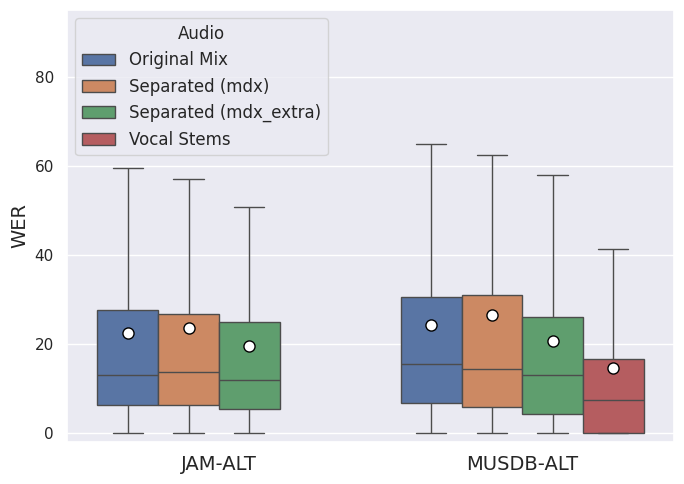

/tmp/ipykernel_767876/3866677747.py:62: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda rows: (rows["ins"].sum() + rows["sub"].sum() + rows["del"].sum()) / (rows["hit"].sum() + rows["sub"].sum() + rows["del"].sum()) * 100)


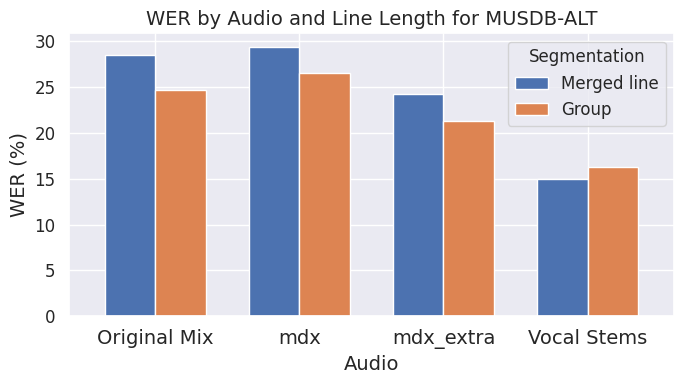

In [5]:
FONTSIZE = 14
fig, ax = plt.subplots(1, 1, figsize=(7, 5), sharey=True)
df = df_samples_short.query("level == 'InferLevel.GROUPED_LINE'").copy()
df["audio"] = pd.Categorical(
    df["audio"].replace(
        {
            "original": "Original Mix",
            "mdx": "Separated (mdx)",
            "mdx_extra": "Separated (mdx_extra)",
            "vocal_stem": "Vocal Stems",
        }
    ),
    categories=[
        "Original Mix",
        "Separated (mdx)",
        "Separated (mdx_extra)",
        "Vocal Stems",
    ],
    ordered=True,
)
df["dataset"] = df["dataset"].str.upper()
df["wer"] = df["wer"] * 100
sns.boxplot(
    data=df,
    x="dataset",
    y="wer",
    hue="audio",
    ax=ax,
    showmeans=True,
    showfliers=False,
    meanprops={
        "marker": "o",
        "markerfacecolor": "white",
        "markeredgecolor": "black",
        "markersize": "8",
    },
)
ax.get_xaxis().label.set_visible(False)
ax.set_ylabel("WER", fontsize=FONTSIZE)
# ax.set_xlabel("Dataset", fontsize=FONTSIZE-2)
plt.xticks(fontsize=FONTSIZE)
ax.set_ylim(-2, 95)
# ax.tick_params(axis="both", which="major", labelsize=FONTSIZE)
plt.legend(
    loc="upper left",
    title="Audio",
    prop={"size": FONTSIZE - 2},
    title_fontsize=FONTSIZE - 2,
)
plt.tight_layout()
plt.show()
fig.savefig(results_dir / "short_wer_box.pdf")
# Compute mean WER for MUSDB-ALT, for both merged and grouped lines, as a pivot table
# Compute mean WER for MUSDB-ALT, for both merged and grouped lines, as a pivot table
# Set desired order for levels and audios
level_order = ["Merged line", "Group"]
audio_order = ["Original Mix", "mdx", "mdx_extra", "Vocal Stems"]

table = (
    df_samples_short.query("dataset == 'musdb-alt' and level in ['InferLevel.MERGED_LINE', 'InferLevel.GROUPED_LINE']")
    .groupby(["audio", "level"])
    .apply(lambda rows: (rows["ins"].sum() + rows["sub"].sum() + rows["del"].sum()) / (rows["hit"].sum() + rows["sub"].sum() + rows["del"].sum()) * 100)
    .rename(index={
        "original": "Original Mix",
        "mdx": "mdx",
        "mdx_extra": "mdx_extra",
        "vocal_stem": "Vocal Stems",
        "InferLevel.MERGED_LINE": "Merged line",
        "InferLevel.GROUPED_LINE": "Group",
    })
    .round(2)
    .unstack("level")
    .rename(columns={
        "InferLevel.MERGED_LINE": "Merged line",
        "InferLevel.GROUPED_LINE": "Group",
    })
    .reindex(index=audio_order)
    [level_order]
)
# Display the table as a bar chart
ax2 = table.plot.bar(rot=20, figsize=(7, 4), width=0.7)
ax2.set_ylabel("WER (%)", fontsize=FONTSIZE)
ax2.set_xlabel("Audio", fontsize=FONTSIZE)
ax2.set_title("WER by Audio and Line Length for MUSDB-ALT", fontsize=FONTSIZE)
ax2.legend(title="Segmentation", fontsize=FONTSIZE-2, title_fontsize=FONTSIZE-2)
plt.xticks(fontsize=FONTSIZE, rotation=0)
plt.yticks(fontsize=FONTSIZE-2)
plt.tight_layout()
plt.show()

## Long form

### Load data

In [42]:
algos = [LongFormAlgo.NATIVE, LongFormAlgo.RMSVAD]
audios = [
    "original",
    "mdx_extra",
    "vocal_stem",
]

samples, chunks, edits = [], [], []
for audio, algo in itertools.product(audios, algos):
    for idx in range(NUM_ITERATIONS):
        s, c, e = read_pz(infer_dir() / f"01-ss-long-{audio}-{algo}-{idx}" / "dataframes.pz")
        for df in s, c, e:
            df["audio"] = audio
            df["algo"] = str(algo)
            df["iter_idx"] = idx
        samples.append(s)
        chunks.append(c)
        edits.append(e)
df_samples_long = pd.concat(samples)  # samples_long == song
df_chunks_long = pd.concat(chunks)
df_edits_long = pd.concat(edits)

### Dataset summary

In [43]:
df = df_samples_long.query(
    "algo == 'LongForrlgo.NATIVE' and audio == 'original' and iter_idx ==0"
).copy()
df["len"] = df["hit"] + df["sub"] + df["del"]
df["nl"] = df["hit_nl"] + df["sub_nl"] + df["del_nl"]
df["bv"] = df["hit_bv"] + df["sub_bv"] + df["del_bv"]

# Group by 'dataset' and calculate metrics
result = (
    df.groupby("dataset")
    .agg(
        num_unique_uid=("uid", "nunique"),  # Number of unique uids
        total_duration_mins=(
            "duration",
            lambda x: x.sum() / 60,
        ),  # Total duration in minutes
        nl_len_percent=(
            "nl",
            lambda x: (x.sum() / df.loc[x.index, "len"].sum()) * 100,
        ),  # nl/len %
        bv_len_percent=(
            "bv",
            lambda x: (x.sum() / df.loc[x.index, "len"].sum()) * 100,
        ),  # bv/len %
    )
    .reset_index()
)

# Rename columns for clarity
result.columns = [
    "dataset",
    "num_unique_uid",
    "total_duration (mins)",
    "nl/len %",
    "bv/len %",
]
result = result.round(2)

# Display the result
display(result)

,dataset,num_unique_uid,total_duration (mins),nl/len %,bv/len %
0,jam-alt,79,283.29,4.68,4.66
1,musdb-alt,39,166.34,3.27,4.90


### Error rate table

In [44]:
rename_dict = {
    "hit_r": "HR",
    "sub_r": "SR",
    "del_r": "DR",
    "ins_r": "IR",
    "wer": "WER",
    "hal_r": "IR_Hal",
    "del_nl_r": "DR_NL",
    "del_bv_r": "DR_BV",
}
rename_dict_dataset = {
    "jam-alt": "JAM-ALT",
    "musdb-alt": "MUSDB-ALT",
}
rename_dict_algo = {
    "LongFormAlgo.NATIVE": "Default",
    "LongFormAlgo.RMSVAD": "RMS-VAD",
}
rename_dict_audio = {
    "original": "Original Mix",
    "mdx_extra": "Separated Vocals",
    "vocal_stem": "Vocal Stem",
}
df = df_chunks_long.copy()
df["hit"] = (df["typ"] == "hit") * df["len"]
df["sub"] = (df["typ"] == "sub") * df["len"]
df["ins"] = (df["typ"] == "ins") * df["len"]
df["del"] = (df["typ"] == "del") * df["len"]
df["hal"] = (df["ins"] > 10) * df["ins"] + (df["sub"] > 10) * df["sub"]
df["del_nl"] = (df["typ"] == "del") * df["nl"]
df["del_bv"] = (df["typ"] == "del") * df["bv"]
pivot_table = (
    df.groupby(["audio", "algo", "dataset"])[
        ["sub", "hit", "del", "ins", "hal", "del_nl", "del_bv"]
    ]
    .sum()
    .assign(
        sub_r=lambda df: df["sub"] / (df["hit"] + df["sub"] + df["del"]) * 100,
        ins_r=lambda df: df["ins"] / (df["hit"] + df["sub"] + df["del"]) * 100,
        del_r=lambda df: df["del"] / (df["hit"] + df["sub"] + df["del"]) * 100,
        wer=lambda df: (df["sub"] + df["ins"] + df["del"])
        / (df["hit"] + df["sub"] + df["del"])
        * 100,
        hal_r=lambda df: (df["hal"]) / (df["hit"] + df["sub"] + df["del"]) * 100,
        del_nl_r=lambda df: df["del_nl"] / (df["hit"] + df["sub"] + df["del"]) * 100,
        del_bv_r=lambda df: df["del_bv"] / (df["hit"] + df["sub"] + df["del"]) * 100,
    )
    .reset_index()
    .pivot(
        index=["audio", "algo"],
        columns=["dataset"],
        values=["wer", "sub_r", "del_r", "ins_r", "hal_r", "del_nl_r", "del_bv_r"],
    )
    .swaplevel(0, 1, axis=1)
    .sort_index(axis=1, level=0, sort_remaining=False)
    .rename(columns=rename_dict, level=1)
    .rename(columns=rename_dict_dataset, level=0)
    .rename(index=rename_dict_algo, level=1)
    .rename(index=rename_dict_audio, level=0)
    .rename_axis(
        index={"audio": "Audio", "algo": "Algorithm"}, columns={"dataset": "Dataset"}
    )
)

# Reorder the audio part of the index
audio_order = ["Original Mix", "Separated Vocals", "Vocal Stem"]
pivot_table = pivot_table.reindex(audio_order, level="Audio")

table_styles = [
    {"selector": "toprule", "props": ":\\toprule;"},
    {"selector": "midrule", "props": ":\\hline;"},
    {"selector": "bottomrule", "props": ":\\bottomrule;"},
]
pivot_table = (
    pivot_table.style.format(
        "{:.2f}",
        na_rep="-",
        subset=pd.IndexSlice[
            :, pd.IndexSlice[:, ["WER", "SR", "DR", "IR", "IR_Hal", "DR_NL", "DR_BV"]]
        ],
    )
    # .format("{:.0f}", na_rep="-", subset=pd.IndexSlice[:, pd.IndexSlice[:, ["H-5G"]]])
    .highlight_min(
        props="font-weight:bold;",
        subset=pd.IndexSlice[pd.IndexSlice[["Original Mix", "Separated Vocals"]], :],
    )
)
display(pivot_table)

latex_table = (
    pivot_table.format_index(escape="latex")
    .format_index(escape="latex", axis=1)
    .to_latex(convert_css=True)
)
(results_dir / "long_error_table.tex").write_text(latex_table)

1185

### Long-form box plots

/tmp/ipykernel_3946228/3733819425.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(combine_wer)


/tmp/ipykernel_3946228/3733819425.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fs)
/tmp/ipykernel_3946228/3733819425.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=fs)


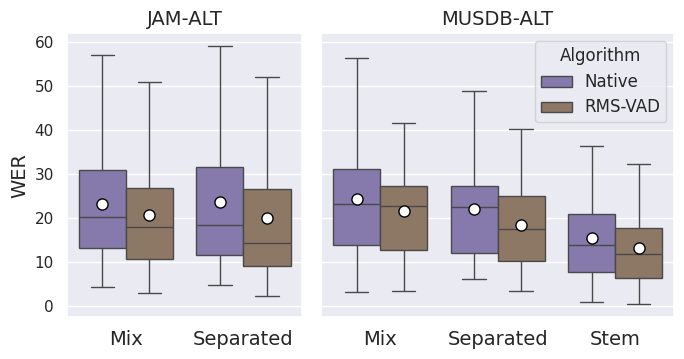

In [45]:
def combine_wer(rows):
    hit = rows["hit"].sum()
    ins = rows["ins"].sum()
    dels = rows["del"].sum()
    sub = rows["sub"].sum()
    wer = (ins + sub + dels) / (hit + sub + dels)
    return wer


pivot_table = (
    df_samples_long.groupby(["dataset", "audio", "algo"])
    .apply(combine_wer)
    .reset_index(name="wer")
    .pivot(index=["dataset", "audio"], columns="algo", values="wer")
    .reindex(["jam-alt", "musdb-alt"], level=0)
    .reindex(["original", "mdx_extra", "vocal_stem"], level=1)
)
display((pivot_table * 100).style.format("{:.2f}"))

plot_data = (
    df_samples_long
    .replace({"algo": {"LongFormAlgo.NATIVE": "Native", "LongFormAlgo.RMSVAD": "RMS-VAD",}})
    .rename(columns={"algo": "Algorithm"})
    .replace({"audio": {"original": "Mix", "mdx_extra": "Separated", "vocal_stem": "Stem"}})
    .rename(columns={"audio": "Audio"})
)

fig, axes = plt.subplots(
    1, 2, figsize=(7, 3.75), sharey=True, gridspec_kw={"width_ratios": [2, 3]}
)
datasets = ["jam-alt", "musdb-alt"]
colors = sns.color_palette()
for ax, dataset in zip(axes, datasets):
    data = plot_data.query("dataset==@dataset").copy()
    data["wer"] *= 100
    sns.boxplot(
        data=data,
        x="Audio",
        y="wer",
        hue="Algorithm",
        ax=ax,
        showmeans=True,
        showfliers=False,
        palette=[colors[4], colors[5]],
        meanprops={
            "marker": "o",
            "markerfacecolor": "white",
            "markeredgecolor": "black",
            "markersize": "8",
        },
    )
    fs = 14
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=fs)
    ax.set_title(dataset.upper(), fontsize=fs)
    ax.set_ylabel("WER", fontsize=fs)
    ax.get_xaxis().label.set_visible(False)
    # ax.set_xlabel("Audio", fontsize=fs)
    # ax.set_ylim(-0.01, 1)
axes[1].legend_.set_title("Algorithm")
for text in axes[1].legend_.get_texts():
    text.set_fontsize(fs - 2)
axes[0].legend_.remove()

plt.tight_layout()
fig.savefig(results_dir / "long_wer_box.pdf")
plt.show()

### By-Language results + SoTA

In [46]:
def combine_wer(rows):
    rows = rows.query("not(typ in ['ins', 'sub'] and len > 15)")
    rows = rows.groupby("typ")["len"].sum()
    hit = rows["hit"]
    ins = rows["ins"]
    dels = rows["del"]
    sub = rows["sub"]
    wer = (ins + sub + dels) / (hit + sub + dels)
    return wer


pivot_table = (
    df_chunks_long.query("dataset == 'jam-alt'")
    .groupby(["audio", "algo", "language"])
    .apply(combine_wer)
    .reset_index(name="wer")
    .pivot(index=["audio", "algo"], columns="language", values="wer")
)
# Reorder the audio part of the index
audio_order = ["original", "mdx_extra"]
pivot_table = pivot_table.reindex(audio_order, level="audio")
# Add a new row for "lyricwhiz"
lyricwhiz_row = pd.DataFrame(
    {"en": [0.237]},
    index=pd.MultiIndex.from_tuples([("lyricwhiz", "")], names=["audio", "algo"]),
)
pivot_table = pd.concat([pivot_table, lyricwhiz_row])
pivot_table = (
    (pivot_table * 100)
    .style.format("{:.2f}", na_rep="-", escape="latex")
    .format_index(escape="latex")
    .highlight_min(
        axis=0,
        props="font-weight:bold;",
        subset=pd.IndexSlice[
            pd.IndexSlice[:, :], pivot_table.columns.difference([("lyricwhiz", "")])
        ],
    )
    .set_table_styles(
        [
            {"selector": "toprule", "props": ":hline;"},
            {"selector": "midrule", "props": ":hline;"},
            {"selector": "bottomrule", "props": ":hline;"},
            {"selector": "thead", "props": [("border-bottom", "2px solid black")]},
            {
                "selector": "tbody tr:last-of-type",
                "props": [("border-top", "2px solid black")],
            },
        ],
        overwrite=False,
    )
)
display(pivot_table)
latex_table = pivot_table.to_latex(
    hrules=True, clines="all;data", column_format="|l|" + "r|" * 5, convert_css="true"
)
# print(latex_table)
(results_dir / "long_error_table_lang.tex").write_text(latex_table)
# pivot_table.plot(kind="bar", title=model)

/tmp/ipykernel_3946228/208051879.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(combine_wer)


678